In [1]:
from Pointcloud.Modules.Object import Pointcloud
from Pointcloud.Modules.Processor import Processor
from Pointcloud.Modules.Utils import TorchUtils

import random
import torch
from tqdm import tqdm
import meshplot as mp
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# folder = "models/Stanford/bunny/bunny/"

# gt_pc = Pointcloud.sampleObj(folder + "bunny.obj", 200000)
# gt_pp = Processor(gt_pc)

# sample_pc = Pointcloud.loadPly(folder + "reconstruction/bun_zipper.ply")
# sample_pp = Processor(sample_pc)

# Printed dataset
# objectname = "Suit_man.obj"

# gt_pc = Pointcloud.sampleObj("PrintedDataset/gt/" + objectname, 200000)
# gt_pp = Processor(gt_pc)

# sample_pc = Pointcloud.loadObj("PrintedDataset/noisy/" + objectname)
# sample_pp = Processor(sample_pc)


# Artificial dataset
objectname = "common-3d-test-models-master/fandisk.obj"
# objectname = "common-3d-test-models-master/ogre.obj"
# objectname = "common-3d-test-models-master/stanford-bunny.obj"
# objectname = "cube.obj"
# objectname = "sphere.obj"
# objectname = "pyramid.obj"
# objectname = "torus.obj"

gt_pc = Pointcloud.sampleObj(objectname, 2 ** 14)
gt_pp = Processor(gt_pc)

sample_pc = Pointcloud.sampleObj(objectname, 2 ** 10)
sample_pp = Processor(sample_pc)

In [ ]:
gt_pos = gt_pp.graph.pos
noisy_pos = sample_pp.graph.pos

radius = TorchUtils.pointcloudRadius(noisy_pos)

cd = TorchUtils.ChamferDistance(gt_pos, noisy_pos)
hd = TorchUtils.HausdorffDistance(gt_pos, noisy_pos)
pd = TorchUtils.PaperDistance(gt_pos, noisy_pos)

print(cd.mean(dim=0), hd.max(dim=0).values, pd.mean(dim=0))

point_scaling = 12

# plot = mp.plot(noisy_pos.numpy(), c=cd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / point_scaling})
# plot = mp.plot(noisy_pos.numpy(), c=hd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / point_scaling})
plot = mp.plot(noisy_pos.numpy(), c=pd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / point_scaling})
plot = mp.plot(gt_pos.numpy(), c=TorchUtils.ChamferDistance(noisy_pos, gt_pos)[:gt_pos.shape[0]].numpy(), shading={"point_size": radius / point_scaling / 2})
c = torch.zeros((gt_pos.size(0) + noisy_pos.size(0),))
c[:gt_pos.size(0)] = 1
plot = mp.plot(torch.cat([noisy_pos, gt_pos]).numpy(), c=c.numpy(), shading={"point_size": radius / point_scaling / 2})

tensor(0.0003) tensor(0.0543) tensor(0.0039)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4139499…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4139499…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4139499…

In [ ]:
k = 12
noise_level = 0.3

_graph = sample_pp.graph
_graphBuilder = sample_pp.graphBuilder
_noise = sample_pp.noise

_graph.edge_index = _graphBuilder.getKNNEdgeIndex(k)
_graphBuilder.setAndFlipNormals(flip=False)

_pos = _graph.pos
_edge_index = _graph.edge_index

l = TorchUtils.averageEdgeLength(_pos, _edge_index)
_noise.generateNoise(noise_level, l, keepNormals=False)
_graphBuilder.setAndFlipNormals(flip=True)

Creating MST..: 100%|██████████| 12288/12288 [00:00<00:00, 39418.53it/s]


In [ ]:
_graph = sample_pp.graph
_pos = _graph.pos
_n = _graph.n

pd = TorchUtils.PaperDistance(gt_pp.graph.pos, _pos)
plot = mp.plot(_pos.numpy(), c=pd[:_pos.shape[0]].numpy(), shading={"point_size": radius / 2})

plot = mp.plot(_pos.numpy(), shading={"point_size": radius / 2})
_ = plot.add_lines(_pos.numpy(), (_pos + 2 * l * _n).numpy(), shading={"line_color": "black", "line_width": 0.1})

# sample_pp.denoise()

pd = TorchUtils.PaperDistance(gt_pp.graph.pos, _pos)
plot = mp.plot(_pos.numpy(), 
            #    c=pd[:_pos.shape[0]].ceil_().numpy(),
                 shading={"point_size": radius / 2, "point_color": "green"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3772394…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3772394…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3772394…

In [ ]:
################################
##   Decomposition Detailed   ##
################################

noisy_graph_pos = sample_pp.graph.pos.clone()
N = noisy_graph_pos.size(0)
kashfhabnaefjasnfnkas = (2 * 64 / k) ** 0.5 * l
d = 2 * l

_graph = sample_pp.graph

angle = torch.pi * 4 / 12
n = sample_pp.graph.n
selection = sample_pp.selector.getKNNSelection(2 ** 6)
nvt = sample_pp.decompositionor.getBetterFilteredNVT(selection, n, angle)
filtered_normals = nvt.getVUSmoothedNormals(n)
decomposition = sample_pp.decompositionor.getBetterFilteredNVT(selection, filtered_normals, angle)
classes = decomposition.getClasses()

In [ ]:
# Pos
_pos = _graph.pos
size = _pos.max(dim=1).values - _pos.min(dim=1).values
other_pos = _pos.clone()
other_pos[:, 0] += radius * 2
combined_pos = torch.cat([_pos, other_pos], dim=0)

# Color
error = classes
other_color = error.clone()
combined_color = torch.cat([error, other_color], dim=0)
mask = combined_color == 1

# Edge vectors
other_Edges = sample_pp.getVUDecomposition().eigvec[..., 2]
my_Edges = decomposition.eigvec[..., 0]
edges = torch.cat([my_Edges, other_Edges], dim=0)

# Plot
plot = mp.plot(combined_pos.numpy(), c=combined_color.numpy(), shading={"point_size": radius / 12})
_ = plot.add_lines(combined_pos[mask].numpy(), (combined_pos + edges * l * 4)[mask].numpy(), shading={"line_color": "green"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(6.1814871…

Vertex updating: 1it [00:00, 26.55it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 32.10it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 25.95it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 27.35it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 27.27it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 22.90it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 27.34it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 26.41it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 25.58it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 17.51it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 32.26it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 28.38it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 26.39it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 28.01it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 26.14it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 28.94it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 32.79it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 30.81it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 29.13it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 30.76it/s, Comparing Error=0.000386]


Stopped cause new error was 3.86E-04 compaired to previous error 3.86E-04


Vertex updating: 1it [00:00, 17.33it/s, Comparing Error=0.000431]


Stopped cause new error was 4.31E-04 compaired to previous error 3.86E-04


Vertex updating: 15it [00:00, 26.74it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 1it [00:00, 24.15it/s, Comparing Error=0.000418]


Stopped cause new error was 4.18E-04 compaired to previous error 3.86E-04


Vertex updating: 15it [00:00, 26.18it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 1it [00:00, 24.65it/s, Comparing Error=0.000407]


Stopped cause new error was 4.07E-04 compaired to previous error 3.86E-04


Vertex updating: 15it [00:00, 26.67it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 1it [00:00, 28.27it/s, Comparing Error=0.000397]


Stopped cause new error was 3.97E-04 compaired to previous error 3.86E-04


Vertex updating: 15it [00:00, 25.32it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 1it [00:00, 23.69it/s, Comparing Error=0.000389]


Stopped cause new error was 3.89E-04 compaired to previous error 3.86E-04


Vertex updating: 15it [00:00, 25.02it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 2it [00:00, 24.67it/s, Comparing Error=0.00042] 


Stopped cause new error was 4.20E-04 compaired to previous error 3.83E-04


Vertex updating: 15it [00:00, 23.58it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 2it [00:00, 26.21it/s, Comparing Error=0.000402]


Stopped cause new error was 4.02E-04 compaired to previous error 3.80E-04


Vertex updating: 15it [00:00, 25.61it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 2it [00:00, 24.96it/s, Comparing Error=0.000388]


Stopped cause new error was 3.88E-04 compaired to previous error 3.78E-04


Vertex updating: 15it [00:00, 23.72it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 2it [00:00, 23.88it/s, Comparing Error=0.00038] 


Stopped cause new error was 3.80E-04 compaired to previous error 3.78E-04


Vertex updating: 15it [00:00, 24.51it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


Vertex updating: 4it [00:00, 24.76it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.78E-04


Vertex updating: 15it [00:00, 22.45it/s, Comparing Error=0.000379]


Stopped cause new error was 3.79E-04 compaired to previous error 3.79E-04


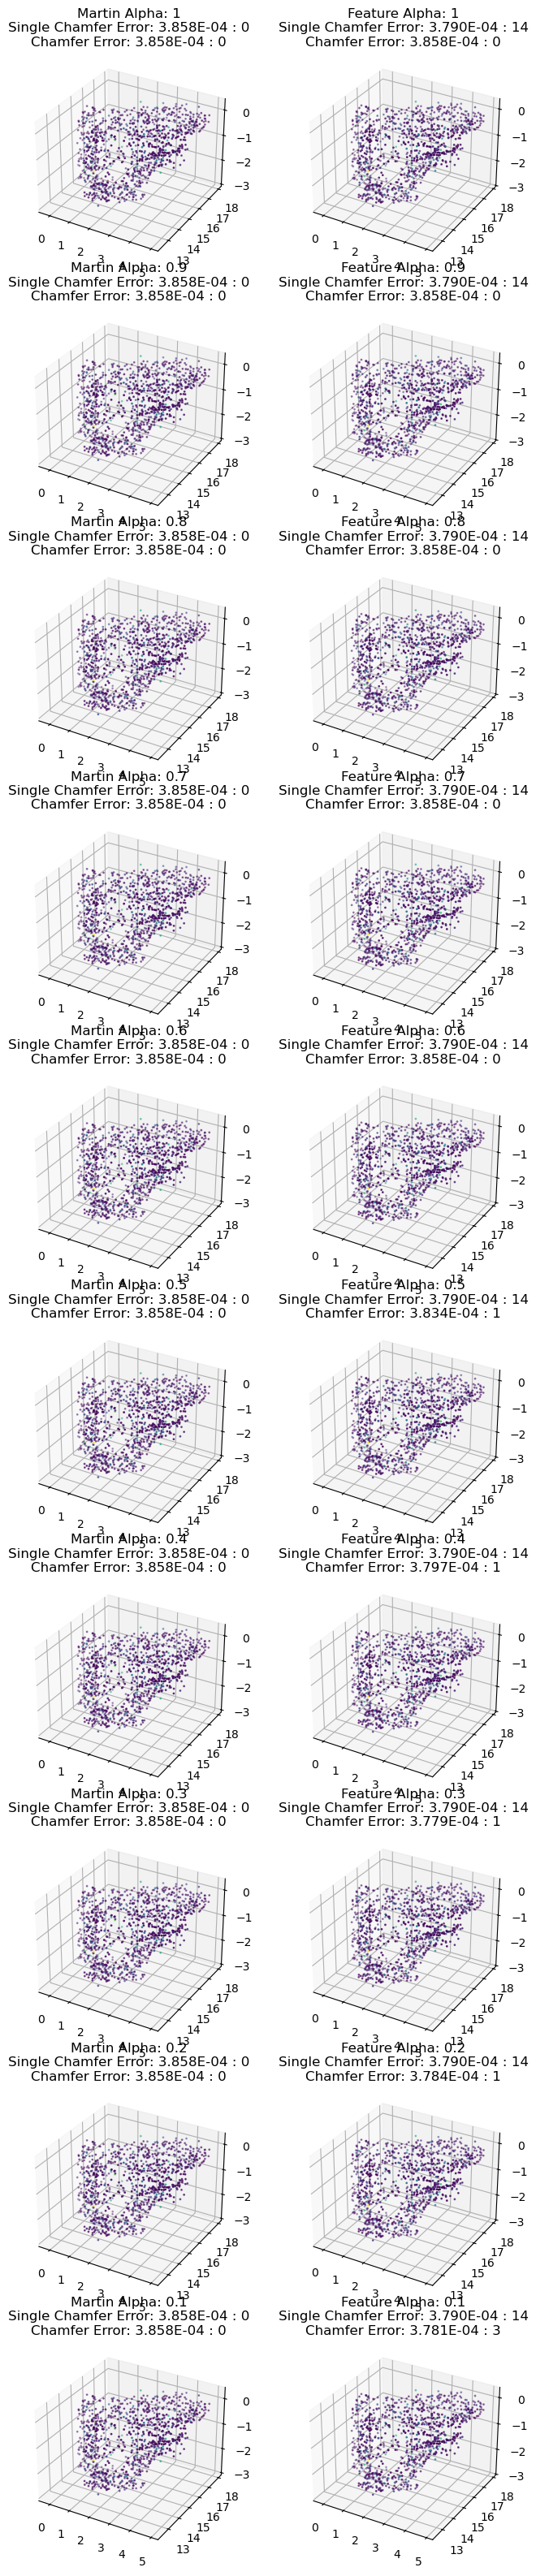

In [ ]:
k = 8
l = TorchUtils.averageEdgeLength(sample_pp.graph.pos, sample_pp.selector.getKNNSelection(6).getEdgeIndex())

_denoiser = sample_pp.denoiser

strategies = [
    {
        0: _denoiser.dummy_step,
        1: _denoiser.dummy_step,
        2: _denoiser.dummy_step
    },
    {
        0: _denoiser.feature_step,
        1: _denoiser.feature_step,
        2: _denoiser.feature_step
    }
]
alphas = [
    [1, 1, 1],
    [0.9, 0.9, 0.9],
    [0.8, 0.8, 0.8],
    [0.7, 0.7, 0.7],
    [0.6, 0.6, 0.6],
    [0.5, 0.5, 0.5],
    [0.4, 0.4, 0.4],
    [0.3, 0.3, 0.3],
    [0.2, 0.2, 0.2],
    [0.1, 0.1, 0.1],
]
'''
Fandisk 0.3
Flat 0.8 Martin
Edge 0.5 Feature
Corner 0.03 Feature

Cube 0.3
Flat 0.9 Martin
Edge 0.45 Feature
Corner ?
'''
titles = ["Martin", "Feature"]

cols = strategies
ncols = len(cols)
rows = alphas
nrows = len(alphas)
size = 4
fig = plt.figure(figsize=(size * ncols, size * nrows))
for i, col_value in enumerate(cols):
    for j, row_value in enumerate(rows):
        _pos0, errors0, iteration0 = sample_pp.denoiseUntilMinimumError(
            gt_pp.graph.pos,
            strategy = col_value,
            k = k,
            alpha = row_value,
            d = 2 * l,
            error_funcs = [TorchUtils.ChamferDistance]
        )
        _pos1, errors1, iteration1 = sample_pp.denoiseUntilMinimumError(
            gt_pp.graph.pos,
            strategy = col_value,
            k = k,
            # alpha = row_value,
            d = 2 * l,
            error_funcs = [TorchUtils.ChamferDistance]
        )

        x = _pos1[:, 0].numpy()
        y = _pos1[:, 1].numpy()
        z = _pos1[:, 2].numpy()
        error = errors1[0].numpy()
        ax = fig.add_subplot(nrows, ncols, 1 + i + j*ncols, projection='3d')
        scatter = ax.scatter(x, y, z, c=error[:x.shape[0]], s=1)
        ax.set_title(f"{titles[i]} Alpha: {row_value[0]}\nSingle Chamfer Error: {errors1[0].mean(dim=0):.3E} : {iteration1}\nChamfer Error: {errors0[0].mean(dim=0):.3E} : {iteration0}")

In [10]:
# objectnames = ["cube.obj", "Torus.obj", "common-3d-test-models-master/fandisk.obj", "common-3d-test-models-master/stanford-bunny.obj"]
# objectnames = ["Pyramid.obj", "sphere.obj", "cylinder.obj", "cone.obj"]
# objectnames = ["Triangle514.obj", "common-3d-test-models-master/armadillo.obj", "common-3d-test-models-master/cow.obj", "common-3d-test-models-master/teapot.obj"]

# objectnames = ["Ankylosaurus.obj", "Armor_cat.obj", "Cat_fangs.obj", "Deer.obj"]
# objectnames = ["Direwolf.obj", "Emissary_wolf.obj", "Girl.obj", "Goblin.obj"]
# objectnames = ["Goku.obj", "Messi.obj", "Minion_ghost.obj", "Nut.obj"]
# objectnames = ["Putin.obj", "Snoopy_flying_face.obj", "Snoopy.obj", "Sphagetti_detective.obj"]
objectnames = ["Stitch_guitar.obj", "Stitch_stand.obj", "Suit_man.obj", "Tp.obj"]

# gt_pcs = [Pointcloud.sampleObj(objectname, 2 ** 16) for objectname in objectnames]
# sample_pps = [Processor(Pointcloud.sampleObj(objectname, 2 ** 14)) for objectname in objectnames]
sample_pps = [Processor(Pointcloud.loadObj("PrintedDataset/noisy/" + objectname)) for objectname in objectnames]
gt_pcs = [Pointcloud.sampleObj("PrintedDataset/gt/" + objectname, sample_pps[i].pointcloud.v.size(0) * 4) for i, objectname in enumerate(objectnames)]

for pp in sample_pps:
    pp.preprocessPointcloud(k = 12, noise_level = 0.3)

Creating MST..: 100%|██████████| 600000/600000 [00:27<00:00, 22220.07it/s]


In [11]:
methods = ["Noisy", "CPSD", "CTD-QEM", "Ours"]
error_funcs = [TorchUtils.SingleChamferDistance, TorchUtils.ChamferDistance]

results = []
results_n = []

cols = sample_pps
ncols = len(cols)
rows = methods
nrows = len(rows)
for i, col_value in enumerate(cols):
    col_results = []
    col_results_n = []
    for j, row_value in enumerate(rows):
        l = TorchUtils.averageEdgeLength(col_value.graph.pos, col_value.selector.getKNNSelection(6).getEdgeIndex())
        d = 2 * l
        original_pos = col_value.graph.pos.clone()
        original_n = col_value.graph.n.clone()
        if j == 1:
            alphas = [0.1, 1, 1]
            for _ in tqdm(range(50), desc="Martin's insane number of iterations wtf"):
                decomposition, f_n = col_value.getMartinFeatureDecomposition(r=d)
                classes = decomposition.getVUFeatures(tau=0.3)
                selection = col_value.selector.getKNNSelection(k=8)
                temp_pos = col_value.graph.pos.clone()
                for key in range(3):
                    indices = (classes == key).nonzero().flatten()
                    if indices.size(0) == 0:
                        continue
                    elif key == 0:
                        new_pos = col_value.denoiser.flat_step(selection.filter(indices), f_n, d*20000, alphas[key])
                    elif key == 1:
                        edge_vectors = decomposition.eigvec[..., 0]
                        new_pos = col_value.denoiser.edge_step(selection.filter(indices), f_n, edge_vectors, d*20000, alphas[key])
                    else:
                        new_pos = col_value.denoiser.corner_step(selection.filter(indices), f_n, d*20000, alphas[key])
                    temp_pos[indices] = new_pos
                mask = (temp_pos - original_pos).norm(dim=1) < d
                col_value.graph.pos[mask] = temp_pos[mask]
                col_value.graph.n = f_n
        elif j == 2:
            for _ in range(5):
                _, f_n = col_value.getMyFeatureDecomposition()
                selection = col_value.selector.getKNNSelection(8)
                col_value.graph.pos = col_value.denoiser.feature_step(selection, f_n, d, 1)
                col_value.graph.n = f_n
        elif j == 3:
            alphas = [1, 0.2, 1]
            for _ in range(2):
                decomposition, f_n = col_value.getMyFeatureDecomposition()
                classes = decomposition.getClasses()
                selection = col_value.selector.getKNNSelection(8)
                temp_pos = col_value.graph.pos.clone()
                for key in range(3):
                    indices = (classes == key).nonzero().flatten()
                    if indices.size(0) == 0:
                        continue
                    elif key == 0:
                        new_pos = col_value.denoiser.flat_step(selection.filter(indices), f_n, d*20000, alphas[key])
                    # elif key == 1:
                    #     edge_vectors = decomposition.eigvec[..., 0]
                    #     new_pos = col_value.denoiser.edge_step(selection.filter(indices), f_n, edge_vectors, d, alphas[key])
                    else:
                        new_pos = col_value.denoiser.feature_step(selection.filter(indices), f_n, d*20000, alphas[key])
                    temp_pos[indices] = new_pos
                mask = (temp_pos - original_pos).norm(dim=1) < d
                col_value.graph.pos[mask] = temp_pos[mask]
                col_value.graph.n = f_n

        d_pos = col_value.graph.pos
        col_results.append(d_pos)
        col_value.graph.pos = original_pos
        col_results_n.append(col_value.graph.n)
        col_value.graph.n = original_n
    results.append(col_results)
    results_n.append(col_results_n)

Martin's insane number of iterations wtf: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


In [12]:
for i in range(len(cols)):
    for j, row_value in enumerate(rows):
        d_pos = results[i][j]
        errors = [error_func(gt_pcs[i].v, d_pos) for error_func in error_funcs]
        print(f"{i}, {j} -> {errors[0].mean(dim=0):.4E} and {errors[1].mean(dim=0):.4E}")

0, 0 -> 7.5834E-06 and 2.0093E-05
0, 1 -> 8.4107E-06 and 2.2537E-05
0, 2 -> 4.8662E-06 and 2.3943E-05
0, 3 -> 5.4605E-06 and 1.9884E-05
1, 0 -> 5.9305E-06 and 9.0443E-06
1, 1 -> 5.4485E-06 and 9.4875E-06
1, 2 -> 4.2330E-06 and 1.0741E-05
1, 3 -> 4.5430E-06 and 8.8402E-06
2, 0 -> 2.0745E-06 and 2.3336E-06
2, 1 -> 2.1013E-06 and 2.8930E-06
2, 2 -> 1.5581E-06 and 3.0532E-06
2, 3 -> 1.6684E-06 and 2.2858E-06
3, 0 -> 1.1668E-05 and 3.9939E-05
3, 1 -> 1.1015E-05 and 4.0679E-05
3, 2 -> 9.2466E-06 and 4.9701E-05
3, 3 -> 9.4993E-06 and 4.3659E-05


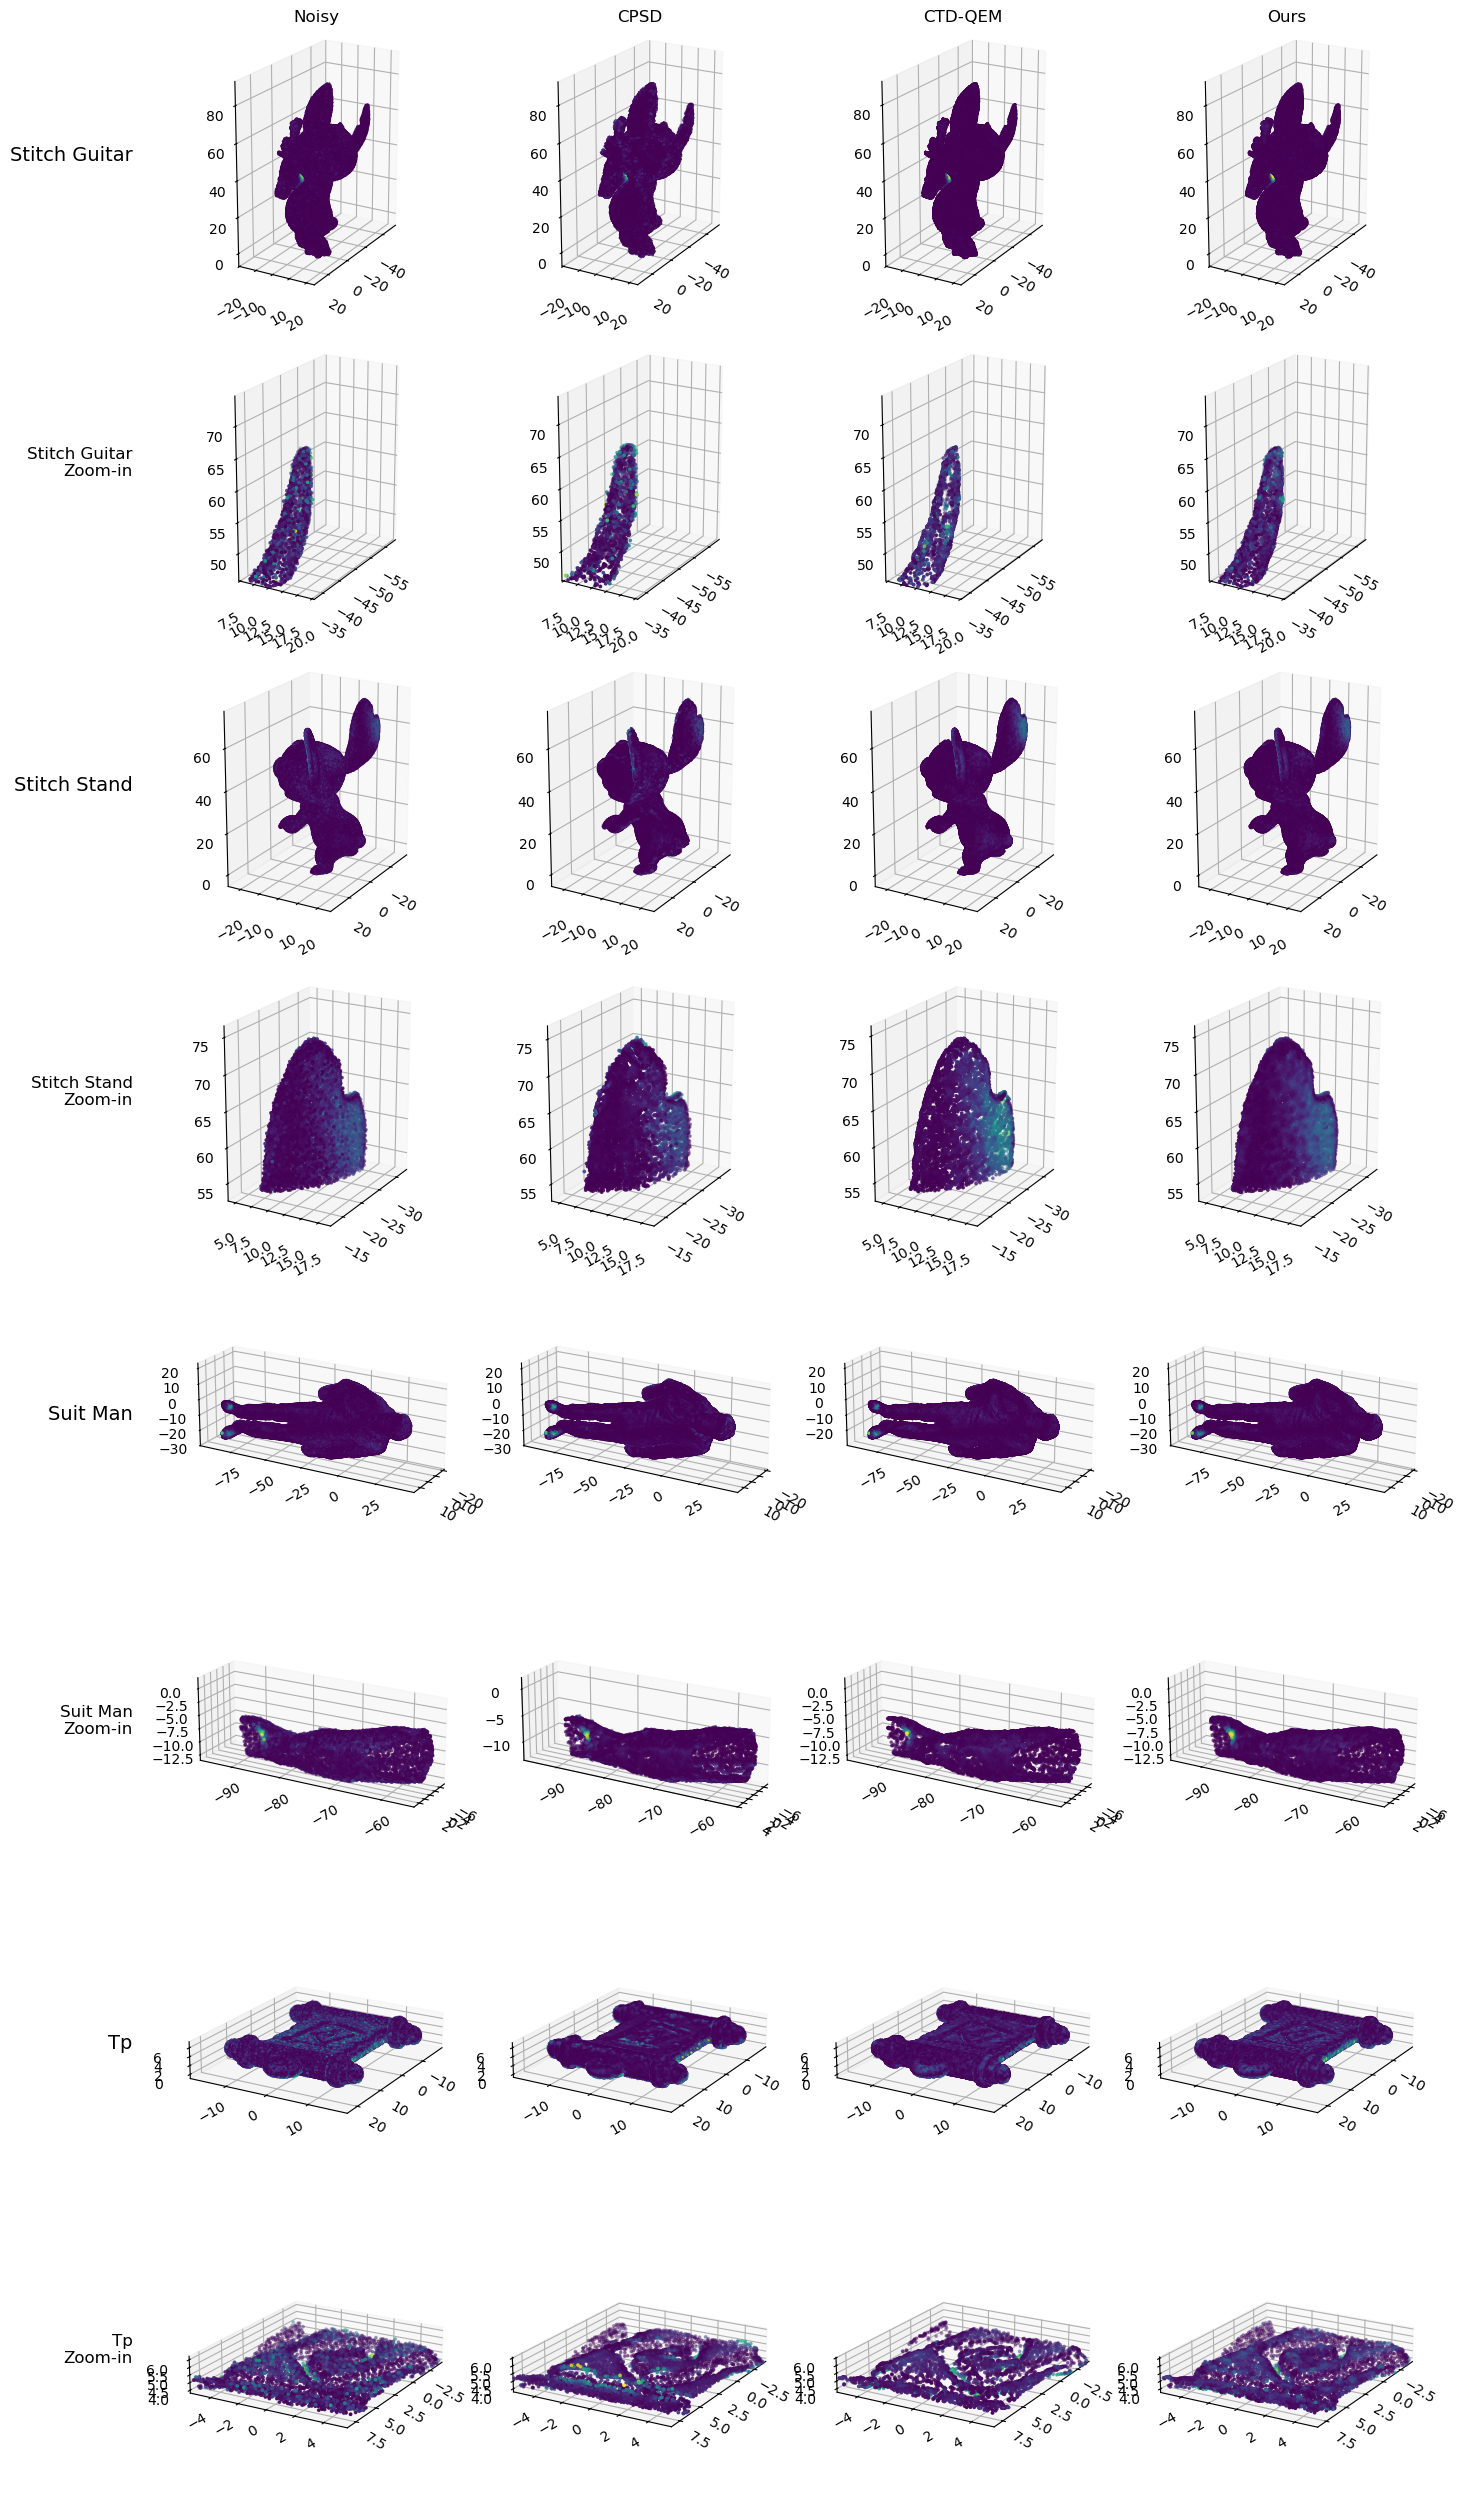

In [20]:
rows = ["Noisy", "CPSD", "CTD-QEM", "Ours"]
# custommodelnames = ["Cube", "Torus", "Fandisk", "Stanford Bunny"]
# custommodelnames = ["Pyramid", "Sphere", "Cylinder", "Cone"]
# custommodelnames = ["Tetrahedron", "Armadillo", "Cow", "Teapot"]

# custommodelnames = ["Ankylosaurus", "Armor Cat", "Cat Fangs", "Deer"]
# custommodelnames = ["Direwolf", "Emissary Wolf", "Girl", "Goblin"]
# custommodelnames = ["Goku", "Messi", "Minion Ghost", "Nut"]
# custommodelnames = ["Putin", "Snoopy Flying Face", "Snoopy", "Spaghetti Detective"]
custommodelnames = ["Stitch Guitar", "Stitch Stand", "Suit Man", "Tp"]
offset = torch.tensor([
    # First models
    # [0.8, 0.8, -0.8],
    # [0, 0, -1],
    # [-0.5, 0.8, -0.5],
    # [0.5, 0.5, 0],
    # Second models
    # [0, 1.0, 0],
    # [0, 0.8, 0],
    # [0, 0.8, -0.7],
    # [0, 1.0, 0],
    # Third models
    # [0, 0.8, 0],
    # [0, 1, 0.7],
    # [0.7, -0.9, -0.5],
    # [0, 0.7, 0]
    # Fourth models
    # [0, 0.8, 0.8],
    # [0.7, 0, 0.5],
    # [0, 0, 0.7],
    # [0, -0.2, -0.8]
    # Fifth models
    # [0.05, 0.7, 0.7],
    # [0.4, 0.8, 0.3],
    # [0, 0.8, 0.8],
    # [-0.02, -0.2, 0.7]
    # sixth models
    # [0, 0, 0.8],
    # [0, 0, 0.8],
    # [0, 0.8, -0.8],
    # [0, -0.8, 0.8]
    # seventh models
    # [0, 0.6, 0.8],
    # [0.8, 0, 0],
    # [0, 0.5, -0.8],
    # [0, 0.9, 0.4]
    # eighth models
    [-0.9, 0.6, 0.4],
    [-0.7, 0.5, 0.8],
    [0, -0.8, -0.1],
    [0, 0, 0.5]
])
nrows = len(rows)
ncols = len(cols)
point_size = 0.5
size = 4
fig = plt.figure(figsize=(size * nrows, 2 * size * ncols))
for i in range(len(cols)):
    for j, row_value in enumerate(rows):
        d_pos = results[i][j]
        errors = [error_func(gt_pcs[i].v, d_pos) for error_func in error_funcs]

        # d_pos = d_pos[:,[2, 0, 1]] * torch.tensor([-1, -1, 1])
        x = d_pos[:, 0].numpy()
        y = d_pos[:, 1].numpy()
        z = d_pos[:, 2].numpy()
        error = (errors[0] / errors[0].max()).numpy()

        ax1 = fig.add_subplot(2*ncols, nrows, 1 + j + 2*i*nrows, projection='3d')
        ax2 = fig.add_subplot(2*ncols, nrows, 1 + j + (2*i+1)*nrows, projection='3d')
        if j == 0:
            fig.text(-0.2, 0.5, s=f"{custommodelnames[i]}", size=14, ha="right", transform=ax1.transAxes)
            # fig.text(-0.2, 0.5, s=f"{pathlib.Path(objectnames[i]).stem.capitalize()}", size=12, ha="right", transform=ax1.transAxes)
        if i == 0:
            ax1.set_title(f"{row_value}")
        bb = d_pos.max(dim=0).values - d_pos.min(dim=0).values
        # Normal
        scatter = ax1.scatter(x, y, z, c=error, s=point_size)
        ax1.set_box_aspect(bb.numpy())
        ax1.view_init(azim=30, elev=20)
        # fig.text(0.5,-0.2, s=f"[sCD, CD] = [{errors[0].mean(dim=0):.3E}, {errors[1].mean(dim=0):.3E}]", size=12, ha="center", transform=ax1.transAxes)
        # if i == 1:
        #     ax1.set_zticks([-0.3, 0.0, 0.3])
        # Zoom
        rpos = (d_pos.max(dim=0).values + d_pos.min(dim=0).values) / 2 + offset[i] * bb / 2
        # rpos = (d_pos.max(dim=0).values + d_pos.min(dim=0).values) / 2 + offset[i][[2, 0, 1]] * bb / 2
        zoom_scale = 6
        scaled_min_bb = rpos - bb / zoom_scale
        scaled_max_bb = rpos + bb / zoom_scale
        x_min, x_max = (scaled_min_bb[0]).numpy(), (scaled_max_bb[0]).numpy()
        y_min, y_max = (scaled_min_bb[1]).numpy(), (scaled_max_bb[1]).numpy()
        z_min, z_max = (scaled_min_bb[2]).numpy(), (scaled_max_bb[2]).numpy()
        mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max) & (z >= z_min) & (z <= z_max)
        x_filtered = x[mask]
        y_filtered = y[mask]
        z_filtered = z[mask]
        scatter = ax2.scatter(x_filtered, y_filtered, z_filtered, c=error[mask], s=point_size*zoom_scale)
        if j == 0:
            fig.text(-0.2, 0.5, s=f"{custommodelnames[i]}\nZoom-in", size=12, ha="right", transform=ax2.transAxes)
        ax2.set_box_aspect(bb.numpy())
        ax2.view_init(azim=30, elev=20)
        # if i == 1:
        #     ax2.set_zticks([-0.3, 0.0, 0.3])
        # if i == 2:
        #     ax2.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax1.tick_params(axis='x', labelrotation=-30)
        ax1.tick_params(axis='y', labelrotation=30)
        ax2.tick_params(axis='x', labelrotation=-30)
        ax2.tick_params(axis='y', labelrotation=30)

        # ax2.set_xlim(-z_max, -z_min)
        # ax2.set_ylim(-x_max, -x_min)
        # ax2.set_zlim(y_min, y_max)
        ax2.set_xlim(x_min, x_max)
        ax2.set_ylim(y_min, y_max)
        ax2.set_zlim(z_min, z_max)

In [24]:
model_i = 0
denoiser_j = 1
v = torch.cat([results[model_i][denoiser_j], gt_pcs[model_i].v])
c = torch.zeros((v.size(0),))
c[:results[model_i][denoiser_j].size(0)] = 1
plot = mp.plot(v.numpy(), c=c.numpy(), shading={"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-10.14115…

Start Plot


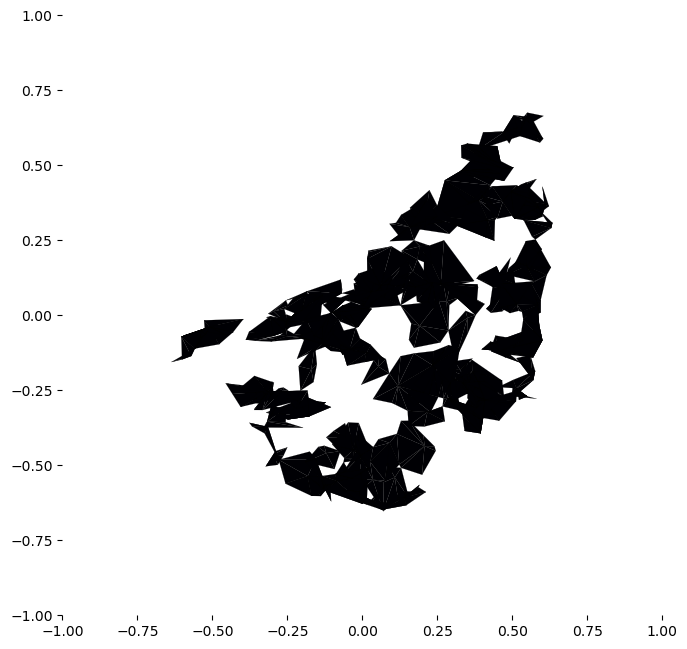

In [ ]:
points = sample_pp.graph.pos
faces = sample_pp.graphBuilder.getRobustLaplacianFaces()

print("Start Plot")

from matplotlib.collections import PolyCollection
import numpy as np

# V, F = [], []
# with open("common-3d-test-models-master/stanford-bunny.obj") as f:
#    for line in f.readlines():
#        if line.startswith('#'):
#            continue
#        values = line.split()
#        if not values:
#            continue
#        if values[0] == 'v':
#            V.append([float(x) for x in values[1:4]])
#        elif values[0] == 'f':
#            F.append([int(x) for x in values[1:4]])
# V, F = np.array(V), np.array(F)-1
V, F = points.numpy(), faces.numpy()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

def frustum(left, right, bottom, top, znear, zfar):
    M = np.zeros((4, 4), dtype=np.float32)
    M[0, 0] = +2.0 * znear / (right - left)
    M[1, 1] = +2.0 * znear / (top - bottom)
    M[2, 2] = -(zfar + znear) / (zfar - znear)
    M[0, 2] = (right + left) / (right - left)
    M[2, 1] = (top + bottom) / (top - bottom)
    M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
    M[3, 2] = -1.0
    return M
def perspective(fovy, aspect, znear, zfar):
    h = np.tan(0.5*np.radians(fovy)) * znear
    w = h * aspect
    return frustum(-w, w, -h, h, znear, zfar)
def translate(x, y, z):
    return np.array([[1, 0, 0, x], [0, 1, 0, y],
                     [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)
def xrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return np.array([[1, 0,  0, 0], [0, c, -s, 0],
                     [0, s,  c, 0], [0, 0,  0, 1]], dtype=float)
def yrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return  np.array([[ c, 0, s, 0], [ 0, 1, 0, 0],
                      [-s, 0, c, 0], [ 0, 0, 0, 1]], dtype=float)

err = TorchUtils.ChamferDistance(gt_pp.graph.pos, points)[:points.size(0)].numpy()
V = (V-(V.max(0)+V.min(0))/2) / max(V.max(0)-V.min(0))
MVP = perspective(25,1,1,100) @ translate(0,0,-3.5) @ xrotate(20) @ yrotate(45)
V = np.c_[V, np.ones(len(V))]  @ MVP.T
V /= V[:,3].reshape(-1,1)
V = V[F]
T =  V[:,:,:2]
Z = -V[:,:,2].mean(axis=1)
zmin, zmax = Z.min(), Z.max()
Z = (Z-zmin)/(zmax-zmin)
C = plt.get_cmap("magma")(err)
I = np.argsort(err)
T, C = T[I,:], C[I,:]
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
collection = PolyCollection(T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black")
ax.add_collection(collection)
plt.show()

In [ ]:
err = 3128
pp = sample_pps[0]
_pos = pp.graph.pos
scale = 4
kashfhabnaefjasnfnkas = scale * TorchUtils.averageEdgeLength(_pos, pp.selector.getKNNSelection(6).getEdgeIndex())
selection = pp.selector.getPointsInRangeSelection(kashfhabnaefjasnfnkas)
neighbors = selection[err]
# neighborhood = torch.cat([torch.tensor([err]), neighbors], dim=0)
neighborhood = neighbors
# print(neighborhood)
v = _pos[neighborhood].numpy()
c = torch.zeros((v.shape[0],)).numpy()
c[neighborhood == err] = 1
plot = mp.plot(v=v, c=c, shading={"point_size": 0.1})
beginning = v
ending = v + pp.graph.n[neighborhood].numpy() * 0.05
_ = plot.add_lines(beginning, ending, shading={"line_color": "red"})
_ = plot.add_lines(_pos[err], _pos[err] + torch.tensor([0, kashfhabnaefjasnfnkas, 0]))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.895701…

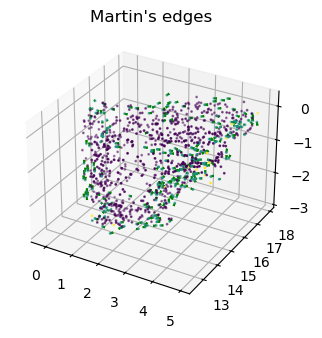

In [ ]:
k = 8
alpha = 0.4

_denoiser = sample_pp.denoiser
_graph = sample_pp.graph
_pos = _graph.pos
titles = ["Martin's edges", "My edges"]

ncols = 2
nrows = 1
size = 4
fig = plt.figure(figsize=(size * ncols, size * nrows))

x = _pos[:, 0].numpy()
y = _pos[:, 1].numpy()
z = _pos[:, 2].numpy()
decomposition, normals = sample_pp.getMyFeatureDecomposition()
classes = decomposition.getClasses(0.35)
edge_vectors = decomposition.eigvec[..., 0]
u, v, w = edge_vectors[:, 0], edge_vectors[:, 1], edge_vectors[:, 2]
error = classes.numpy()
ax = fig.add_subplot(nrows, ncols, 1, projection='3d')
ax.set_title(f"{titles[0]}")
scatter = ax.scatter(x, y, z, c=error, s=1)
mask_edge_vertices = classes == 1
quiver = ax.quiver(
    x[mask_edge_vertices],
    y[mask_edge_vertices],
    z[mask_edge_vertices],
    u[mask_edge_vertices],
    v[mask_edge_vertices],
    w[mask_edge_vertices],
    color="green",
    length=0.1
)

In [ ]:
break
_graph = sample_pp.graph
_denoiser = sample_pp.denoiser
_selector = sample_pp.selector

gt_pos = gt_pp.graph.pos
noisy_graph_pos = _graph.pos.clone()
noisy_graph_n = _graph.n.clone()
N = _graph.num_nodes
kashfhabnaefjasnfnkas = (2 * 64 / k) ** 0.5 * l
d = 200 * l

initial_size = TorchUtils.pointcloudRadius(noisy_graph_pos)

# Do step
M = 24
errors = torch.zeros((M + 1,))
pos_video = torch.zeros((M + 1, N, 3))
pos_video[0] = noisy_graph_pos
errors[0] = TorchUtils.PaperDistance(gt_pos, _graph.pos).mean(dim=0)
for i in tqdm(range(M), desc="Running vertex updating steps"):
    # angle = torch.pi * 4 / 12
    # n = _graph.n
    # selection = _selector.getKNNSelection(2 ** 6)
    # nvt = _decompositionor.getBetterFilteredNVT(selection, n, angle)
    # filtered_n = nvt.getVUFilteredNormals(n)
    # filtered_n = _graph.n
    decomposition, filtered_n = sample_pp.getMyFeatureDecomposition()
    # decomposition = _decompositionor.getBetterFilteredNVT(selection, filtered_normals, angle)
    edge_vectors = decomposition.eigvec[..., 0]
    classes = decomposition.getClasses()
    corners = (classes == 2).nonzero().flatten()
    edges = (classes == 1).nonzero().flatten()
    flats = (classes == 0).nonzero().flatten()
    # non_flats = (features > 0).nonzero().flatten()
    selection = _selector.getKNNSelection(7)
    corner_pos = _denoiser.corner_step(selection.filter(corners), filtered_n, d, 0.02)
    edge_pos = _denoiser.edge_step(selection.filter(edges), filtered_n, edge_vectors, d, 0.02)
    flat_pos = _denoiser.flat_step(selection.filter(flats), filtered_n, d, 0.1)
    # feature_pos = _denoiser.feature_step(selection.filter(non_flats), filtered_n, d)
    _graph.pos[corners] = corner_pos
    _graph.pos[edges] = edge_pos
    _graph.pos[flats] = flat_pos
    # _graph.pos[non_flats] = feature_pos
    # _graph.pos = _graph.pos * (initial_size / TorchUtils.pointcloudRadius(_graph.pos))
    # Calculate error
    errors = TorchUtils.PaperDistance(gt_pos, _graph.pos).mean(dim=0)
    errors[i+1] = errors
    # Save video
    pos_video[i+1] = _graph.pos

_graph.pos = noisy_graph_pos

SyntaxError: 'break' outside loop (2625448229.py, line 1)

In [ ]:
######################
## Error evaluation ##
######################

# Filtering normals works again with larger knn neighbourhood
# However when a normal is so out of line with all its neighbours,
# Isn't the normal itself wrong?
# Next time: find normals where the majority disagrees with the direction
# of the normal of the point. If so, isolate them, visualize them,
# check if they are calculated in the right way and if needed,
# recalculate the normal, because it fucking sucks
_g = _graph
eigvec = decomposition.eigvec

edge_indices = (classes == 2).nonzero().flatten()
random_index = edge_indices[torch.randperm(edge_indices.size(0))[0]]
# random_index = torch.tensor(5021)
v_random = _g.pos[random_index]
neighbour_indices = _g.edge_index[1][_g.edge_index[0] == random_index]
j = torch.cat([random_index[None], neighbour_indices])
vj = _g.pos[j]
angles = (_g.n[_g.edge_index[0]] * _g.n[_g.edge_index[1]]).sum(dim=1)
q1 = angles.quantile(0.25)
q3 = angles.quantile(0.75)
threshold = q1 - (q3 - q1) * 1.5
print(f"Outlier percentage: {(angles < threshold).nonzero().size(0) / _g.num_edges * 100} with threshold: {threshold}")
print(f"Neighbourhood indices: {j}")
print(f"Broken point distance travelled: {(noisy_graph_pos[random_index] - v_random).norm(dim=0)}")
normal_angles = (_g.n[j] * _g.n[random_index][None]).sum(dim=1)
c = normal_angles >= 0.9
plot = mp.plot(vj.numpy(), c=c.numpy(), shading={"point_size": l})
_ = plot.add_lines(v_random[None][torch.zeros_like(j)].numpy(), vj.numpy())
_ = plot.add_lines(vj.numpy(), (vj + filtered_n[j] * l * 0.5).numpy())
_ = plot.add_lines(v_random.numpy(), (v_random + filtered_n[random_index] * l).numpy(), shading={"line_color": "red"})
_ = plot.add_lines(v_random.numpy(), (v_random + eigvec[random_index, 0] * l * 2).numpy(), shading={"line_color": "blue"})
c2 = torch.zeros((_g.num_nodes,))
c2[j] = 1
plot_whole = mp.plot(_g.pos.numpy(), c=c2.numpy(), shading={"point_size": l * 5})
_ = plot_whole.add_lines(noisy_graph_pos[random_index].numpy(), v_random.numpy())
_ = plot_whole.add_lines(v_random.numpy(), (v_random + _g.n[random_index] * l * 2).numpy(), shading={"line_color": "red"})
# _ = plt.hist(angles, 50)

In [ ]:
# Init variables
_graph = sample_pp.graph
N = _graph.num_nodes
E = _graph.num_edges
_pos = _graph.pos
_edge_index = _graph.edge_index
_n = _graph.n
i, j = _edge_index
l = TorchUtils.averageEdgeLength(_pos, _edge_index)

# Do the angle calculations
angles = (_n[i] * _n[j]).sum(dim=1)
meaned = torch.zeros((N,), dtype=torch.float32) \
    .index_reduce_(dim=0, index=i, source=angles.to(torch.float32), reduce="mean")

lower_threshold = (meaned.quantile(0.75) * (-1.5) + meaned.quantile(0.25) * (2.5))
# lower_threshold = 0.75
error_indices = (meaned < lower_threshold).nonzero().flatten()

# Print stuff
# print(meaned.unique(return_counts=True))
print(meaned.quantile(0.75) * (-1.5) + meaned.quantile(0.25) * (2.5))

# Plot stuff
_ = plt.hist(meaned, 50)

# 3D Plot error indices and their normals
plot = mp.plot(
    _pos.numpy(),
    c=(meaned < lower_threshold).numpy(),
    shading={"point_size": 5 * l}
)
_ = plot.add_lines(
    _pos[error_indices].numpy(),
    (_pos[error_indices] + _n[error_indices] * l).numpy()
)

example_error_index = error_indices[torch.randperm(error_indices.size(0))[0]]
neighbour_edges = i == example_error_index
neighbour_indices = j[neighbour_edges]
plot = mp.plot(
    _pos[torch.cat([example_error_index[None], neighbour_indices])].numpy(),
    c=torch.cat([torch.tensor([1]), angles[neighbour_edges]]).numpy(),
    shading={"point_size": l}
)
_ = plot.add_lines(
    _pos[neighbour_indices].numpy(),
    (_pos[neighbour_indices] + _n[neighbour_indices] * l * 0.5).numpy()
)
_ = plot.add_lines(
    _pos[example_error_index].numpy(),
    (_pos[example_error_index] + _n[example_error_index] * l).numpy(),
    shading={"line_color": "red"}
)

In [ ]:
# Print stuff
min_error_i = errors[errors > 0].argmin(dim=0)
print(f"Error was lowest at {min_error_i} with {errors[min_error_i]}")

# Plot stuff
indices = [0, 4, 8, 12, torch.cat([torch.tensor(errors.size(0))[None], (errors == 0).nonzero().flatten()]).min() - 1, min_error_i]
print(f"Showing iterations: {indices}")
for i in indices:
    pos_to_plot = pos_video[i]
    cd = TorchUtils.PaperDistance(gt_pos, pos_to_plot)
    plt.xlabel("Iteration")
    plt.ylabel("Chamfer Distance")
    plot = plt.plot(errors[errors > 0])
    # _ = visGraphs([_graph, sample_gb.graph])
    error = cd[:pos_to_plot.shape[0]]
    # color = (pos_to_plot - noisy_graph_pos).norm(dim=1)
    # color = features
    # if i == 0:
    #     color = features
    plot = mp.plot(pos_to_plot.numpy(), c=error.numpy(), shading={"point_size": radius / 6})
    _ = plot.add_lines(pos_to_plot.numpy(), noisy_graph_pos.numpy())
    _ = plot.add_lines(pos_to_plot.numpy(), (pos_to_plot + n * 0.05).numpy())

# e = eigvec[:, 0, :].clone()
# e[features < 2, :] = 0
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + e * l * 2).numpy(), shading={"line_color": "blue"})
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + _n * l).numpy(), shading={"line_color": "red"})
plt.figure()
centers = pos_video.sum(dim=1, keepdim=True)
_ = plt.plot((pos_video - centers).norm(dim=2).max(dim=1).values[errors > 0].numpy())
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Pointcloud radius")